In [1]:
import re
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez
import py3Dmol

from dotenv import load_dotenv
env_file = '/home/yuan/bio/bio_omics/src/.env'
load_dotenv(dotenv_path = env_file)

%load_ext autoreload
%autoreload 2

src_dir = os.path.dirname(os.getcwd())
print('src direcotry is ', src_dir)
bioomics_dir = '/home/yuan/bio/bio_omics/src'
for _dir in (src_dir, bioomics_dir):
    if _dir not in sys.path:
        sys.path.append(_dir)
print(sys.path)

src direcotry is  /home/yuan/bio/predict_antibody
['/home/yuan/bio/anaconda3/envs/simulate2/lib/python312.zip', '/home/yuan/bio/anaconda3/envs/simulate2/lib/python3.12', '/home/yuan/bio/anaconda3/envs/simulate2/lib/python3.12/lib-dynload', '', '/home/yuan/bio/anaconda3/envs/simulate2/lib/python3.12/site-packages', '/home/yuan/bio/predict_antibody', '/home/yuan/bio/bio_omics/src']


In [2]:
from bioomics import QueryComplex, DistanceAnalyze, DistanceProcess, ProcessPickle
from layout import Layout
from plot_predict import PlotPredict
from plot_binding import PlotBinding
from load_data import LoadData

/home/yuan/bio/predict_antibody/src/plot_binding.py:54: SyntaxWarning: invalid escape sequence '\A'
  ax.set_xlabel('Minus minimum distance of Ca, -$\AA$')
/home/yuan/bio/predict_antibody/src/plot_binding.py:71: SyntaxWarning: invalid escape sequence '\A'
  ax.set_xlabel(f"Minimum distance of the top {col} ranked Ca, $\AA$")


In [3]:
ab_combo2 = QueryComplex(True).ab_combo2()
ab_combo2.head(1)

INFO:mysql.connector:package: mysql.connector.plugins
INFO:mysql.connector:plugin_name: caching_sha2_password
INFO:mysql.connector:AUTHENTICATION_PLUGIN_CLASS: MySQLCachingSHA2PasswordAuthPlugin


,pdb_id,combo_id,chain_combo,ab_chain_no
0,1NSN,1NSN_0_H-L,H-L,H-L


## count contacts based on various cutoff

In [732]:
pfile = '/home/yuan/output/pdb/collect/distance/count_contacts_combo2_distance.pkl'
data = ProcessPickle(pfile).load_pickle()

num_contacts = {}
for cutoff in data:
    sub = pd.DataFrame(data[cutoff])
    num_contacts[cutoff] = pd.merge(sub, ab_combo2, how='inner', on='combo_id')
    print('min-distance cutoff=', cutoff, num_contacts[cutoff].shape)

min-distance cutoff= 1 (109, 9)
min-distance cutoff= 3 (39658, 9)
min-distance cutoff= 5 (49848, 9)
min-distance cutoff= 10 (58862, 9)
min-distance cutoff= 15 (67512, 9)
min-distance cutoff= 20 (77211, 9)
min-distance cutoff= 30 (94416, 9)
min-distance cutoff= 50 (116979, 9)


figure size: 8.5 x 7 cm


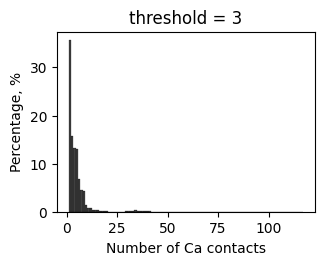

In [751]:
args = {'width_level':1, 'height':7}
fig, ax = Layout(args).one()

cutoff = 3
PlotBinding(num_contacts).hist_contacts(ax, cutoff)

### distance threshold

In [439]:
pfile = '/home/yuan/output/pdb/collect/distance/distance_abag_combo2_distance.pkl'
df = LoadData.abag_dist_stat(pfile)
df.head(1)

number of abag dimer: 77326


,pdb_id,combo_id,chain_combo,ab_chain_no,1th,2th,3th,4th,5th,10th,mean5th,mean10th
0,8G70,8G70_0_D-F,D-F,F,5.484213,3.137771,8.049318,10.151517,13.185985,23.386263,3.159263,3.246582


In [650]:
from sklearn.metrics import roc_curve, auc

def cal_droc(df, col):
    pool = []
    g = df.groupby(['pdb_id', 'ab_chain_no'])
    for (pdb_id, ab_chain_no), sub0 in g:
        sub = sub0[['combo_id', 'ab_chain_no', col]].reset_index()
        sub = sub.sort_values(col)
        if len(sub) > 1:
            sub['y'] = [1,] + [0,] * (len(sub)-1)
        else:
            sub['y'] = [1,] * len(sub)
        pool.append(sub)
    droc = pd.concat(pool)
    droc = droc.dropna()
    print(col, len(droc))
    return dr

In [686]:
data = {}
for col in ('1th','2th','3th','4th','5th','10th','mean5th','mean10th'):
    data[col] = cal_droc(df, col)

1th 77326
2th 77326
3th 77326
4th 77326
5th 77326
10th 77326
mean5th 77326
mean10th 77326


figure size: 17.4 x 6 cm


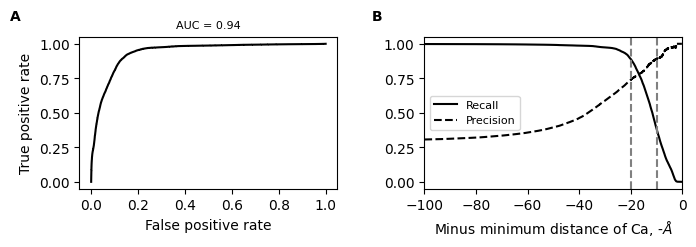

In [725]:
args = {'width_level':3, 'height':6}
label_x = (-50, -38)
label_y = 20
fig, axes = Layout(args).row(label_x, label_y)

col = '1th'
PlotBinding(data).roc(axes[0], col)
PlotBinding(data).precision_recall(axes[1], col)

fig.savefig(f'../figures/abag_distance_threshold_{col}.tif', dpi=300, bbox_inches='tight', pad_inches=.05)

figure size: 17.4 x 6 cm


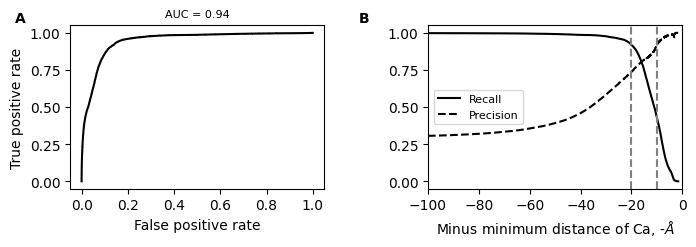

In [731]:
args = {'width_level':3, 'height':6}
label_x = (-40, -50)
label_y = 10
fig, axes = Layout(args).row(label_x, label_y)

col = '2th'
PlotBinding(data).roc(axes[0], col)
PlotBinding(data).precision_recall(axes[1], col)
fig.savefig(f'../figures/abag_distance_threshold_{col}.tif', dpi=300, bbox_inches='tight', pad_inches=.05)

figure size: 17.4 x 6 cm


<Axes: title={'center': 'AUC = 0.94'}, xlabel='False positive rate', ylabel='True positive rate'>

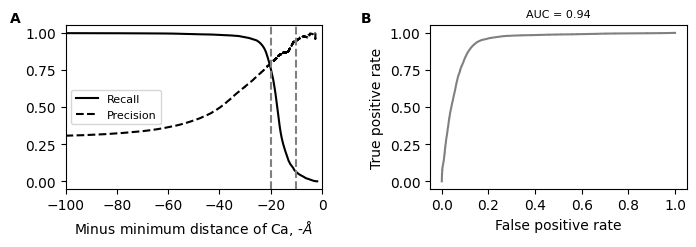

In [712]:
args = {'width_level':3, 'height':6}
label_x = (-40, -50)
label_y = 10
fig, axes = Layout(args).row(label_x, label_y)

col = '5th'
PlotBinding(data).precision_recall(axes[0], col)
PlotBinding(data).roc(axes[1], col)

figure size: 17.4 x 6 cm


<Axes: title={'center': 'AUC = 0.91'}, xlabel='False positive rate', ylabel='True positive rate'>

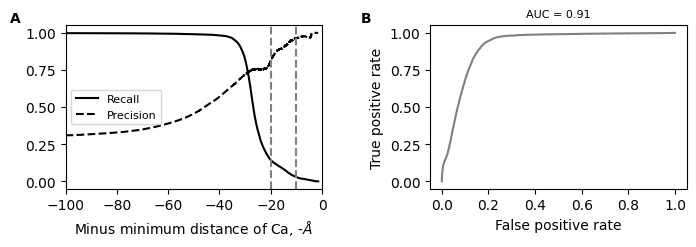

In [713]:
args = {'width_level':3, 'height':6}
label_x = (-40, -50)
label_y = 10
fig, axes = Layout(args).row(label_x, label_y)

col = '10th'
PlotBinding(data).precision_recall(axes[0], col)
PlotBinding(data).roc(axes[1], col)

## binding energy

In [830]:
# load combo2_contacts
cdf0, cdf1 = LoadData.combo2_contacts(ab_combo2)

(137710, 9)
{'pdb_id_x': '3IJH', 'combo_id': '3IJH_0_A-B', 'binding_affinity': -14.6, 'dissociation_constant': 1.9e-11, 'relative_prodigy': 'combo2_contacts/3I/3IJH/3IJH_0_A-B.txt', 'log-kd': -24.68658213676211, 'pdb_id_y': '3IJH', 'chain_combo': 'A-B', 'ab_chain_no': 'B-A'}
no binding: 87651
binding: 50059


figure size: 8.5 x 6 cm


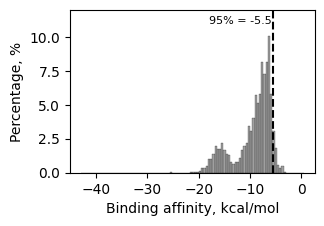

In [831]:
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()

PlotBinding(cdf1).hist_binding_affinity(ax)

figure size: 8.5 x 6 cm


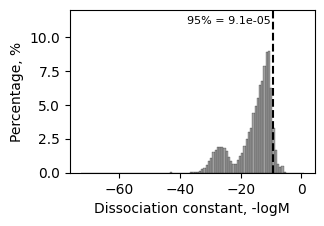

In [832]:
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()

PlotBinding(cdf1).hist_kd(ax)

figure size: 8.5 x 6 cm


Text(0.5, 0, 'Binding affinity, kcal/mol')

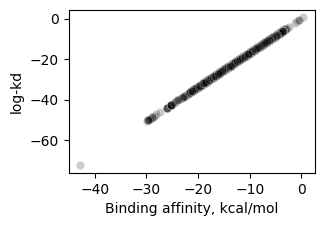

In [838]:
# compare binding affinity with Kd
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()

sns.scatterplot(cdf1, x='binding_affinity', y='log-kd', ax=ax, color='black', alpha=.2)
ax.set_xlabel('Binding affinity, kcal/mol')
ax.set_xlabel('Dissociation constant, logMol')

In [834]:
# compare min-distance with prodigy estimates
# num_contracts is built in the above
non_combo = set(cdf0['combo_id'])
for cutoff in num_contacts:
    sub = num_contacts[cutoff]
    inter = non_combo.intersection(sub['combo_id'])
    print(cutoff, len(sub), len(inter))

1 109 2
3 39658 19
5 49848 146
10 58862 8290
15 67512 16849
20 77211 26482
30 94416 43586
50 116979 66024


### data from combo2_distance

In [4]:
# load 
pfile = '/home/yuan/output/pdb/collect/distance/distance_abag_combo2_distance.pkl'
ddf = LoadData.abag_dist_stat(pfile)
ddf.head(1)

number of abag dimer: 77326


,pdb_id,combo_id,chain_combo,ab_chain_no,1th,2th,3th,4th,5th,10th,mean5th,mean10th
0,8G70,8G70_0_D-F,D-F,F,5.484213,3.137771,8.049318,10.151517,13.185985,23.386263,3.159263,3.246582


In [5]:
# load combo2_contacts
cdf0, cdf1 = LoadData.combo2_contacts(ab_combo2)
cdf1.head(1)

(137710, 9)
{'pdb_id_x': '3IJH', 'combo_id': '3IJH_0_A-B', 'binding_affinity': -14.6, 'dissociation_constant': 1.9e-11, 'relative_prodigy': 'combo2_contacts/3I/3IJH/3IJH_0_A-B.txt', 'log-kd': -24.68658213676211, 'pdb_id_y': '3IJH', 'chain_combo': 'A-B', 'ab_chain_no': 'B-A'}
no binding: 87651
binding: 50059


,pdb_id_x,combo_id,binding_affinity,dissociation_constant,relative_prodigy,log-kd,pdb_id_y,chain_combo,ab_chain_no
0,3IJH,3IJH_0_A-B,-14.6,1.900000e-11,combo2_contacts/3I/3IJH/3IJH_0_A-B.txt,-24.686582,3IJH,A-B,B-A


In [7]:
# not binding
df0 = pd.merge(cdf0, ddf, how='inner', on='combo_id')
df0 = df0[df0['binding_affinity'].isna()]
print('no binding:', len(cdf0))

# bidning
df1 = pd.merge(cdf1, ddf, how='inner', on='combo_id')
df1 = df1[df1['binding_affinity'].notna()]
print('binding:', len(df1))

no binding: 87651
binding: 29706


In [8]:
df1.head(1)

,pdb_id_x,combo_id,binding_affinity,dissociation_constant,relative_prodigy,log-kd,pdb_id_y,chain_combo_x,ab_chain_no_x,pdb_id,chain_combo_y,ab_chain_no_y,1th,2th,3th,4th,5th,10th,mean5th,mean10th
0,9IJS,9IJS_0_A-H,-5.4,0.00011,combo2_contacts/9I/9IJS/9IJS_0_A-H.txt,-9.11503,9IJS,A-H,H,9IJS,A-H,H,32.942871,35.73923,33.79742,38.091509,38.025634,46.673797,7.293953,8.25955


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


figure size: 17.4 x 8 cm


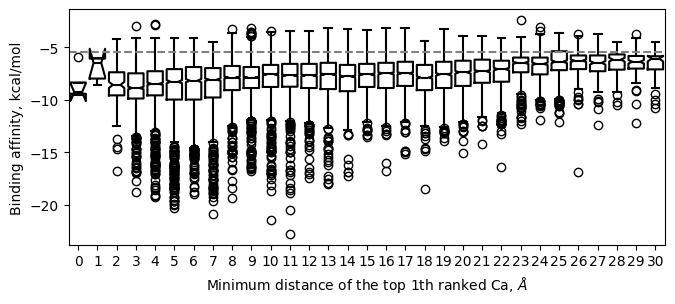

In [9]:
args = {'width_level':3, 'height':8}
fig, ax = Layout(args).one()

col = '1th'
PlotBinding(df1).box_contacts_distance(ax, col)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


figure size: 17.4 x 8 cm


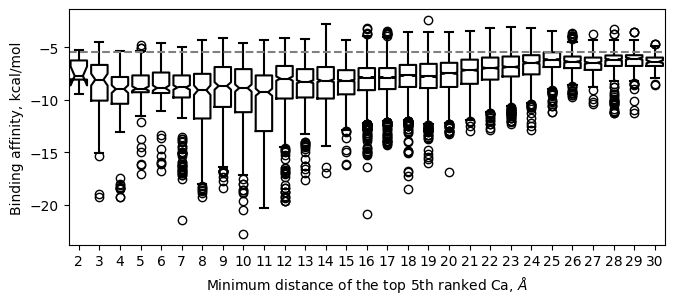

In [10]:
args = {'width_level':3, 'height':8}
fig, ax = Layout(args).one()

col = '5th'
PlotBinding(df1).box_contacts_distance(ax, col)

figure size: 8.5 x 6 cm


<>:7: SyntaxWarning: invalid escape sequence '\A'
<>:7: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_207627/1389713861.py:7: SyntaxWarning: invalid escape sequence '\A'
  ax.set_ylabel("Minimum distance of Ca, $\AA$")


Text(0, 0.5, 'Minimum distance of Ca, $\\AA$')

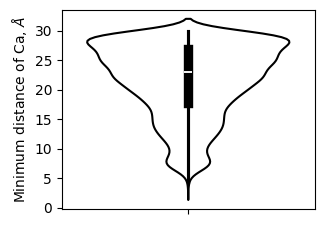

In [11]:
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()

col = '1th'
df3 = df0[df0[col]<=30]
sns.violinplot(df3, y=col, ax=ax, fill=False, color='black')
ax.set_ylabel("Minimum distance of Ca, $\AA$")

figure size: 8.5 x 6 cm


<>:7: SyntaxWarning: invalid escape sequence '\A'
<>:7: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_207627/3755372933.py:7: SyntaxWarning: invalid escape sequence '\A'
  ax.set_ylabel("Minimum distance of Ca, $\AA$")


Text(0, 0.5, 'Minimum distance of Ca, $\\AA$')

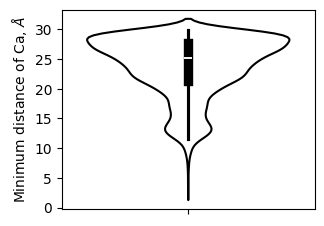

In [12]:
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()

col = '5th'
df3 = df0[df0[col]<=30]
sns.violinplot(df3, y=col, ax=ax, fill=False, color='black')
ax.set_ylabel("Minimum distance of Ca, $\AA$")

<unknown>:54: SyntaxWarning: invalid escape sequence '\A'
<unknown>:71: SyntaxWarning: invalid escape sequence '\A'
<unknown>:54: SyntaxWarning: invalid escape sequence '\A'
<unknown>:71: SyntaxWarning: invalid escape sequence '\A'
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


figure size: 17.4 x 12 cm


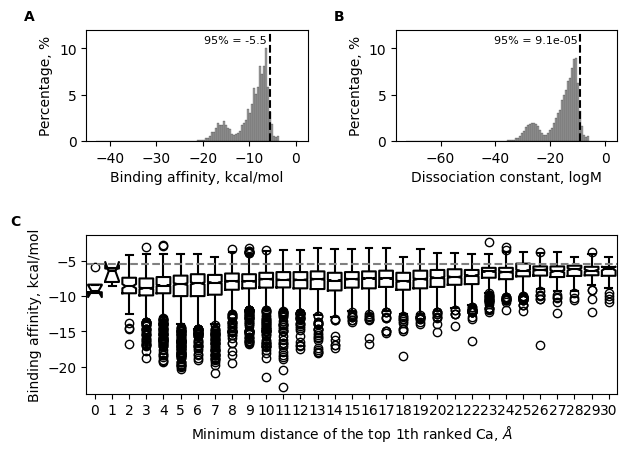

In [23]:
args = {'width_level':3, 'height':12, 'wspace':.4, 'hspace':.7, 'height_ratios':[.7,1]}
panel_xytext = [(-45,15),(-45,15),(-55,15),]
fig, axes = Layout(args).row2_row1(panel_xytext)

PlotBinding(cdf1).hist_binding_affinity(axes[0])
PlotBinding(cdf1).hist_kd(axes[1])
col = '1th'
PlotBinding(df1).box_contacts_distance(axes[2], col)

fig.savefig(f'../figures/contacts_distance_{col}.tif', dpi=300, bbox_inches='tight', pad_inches=.05)

In [323]:
abag = QueryComplex(True).abag_combo2()
abag = abag.drop('pdb_id', axis=1)
print(len(abag))
abag.head(1)

77097


,combo_id,chain_combo,ab_chain_no
0,1NSN_0_H-S,H-S,H


In [324]:
df = ddf.merge(abag, how='inner', on='combo_id')
print(len(df))
df.head(1)

77072


,pdb_id,combo_id,relative_pkl,ranked_dist1,ranked_dist2,1th,5th,10th,mean5th,mean10th,chain_combo,ab_chain_no
0,9IJS,9IJS_0_A-H,combo2_distance/9I/9IJS/9IJS_0_A-H.pkl,"5,7,8,9,12,12,17,22,23,23,24,25,25,25,25,25,25...","5,7,8,8,8,8,9,9,10,10,10,11,11,12,12,12,12,12,...",5.0,8.0,10.0,7.0,8.0,A-H,H


In [4]:
# retrieve interface sequences
table_name = 'combo2_distance'
cutoff = 10
span =5
file_name = f"{table_name}_cutoff{cutoff}_span{span}"
infile = f'/home/yuan/output/pdb/collect/distance/{file_name}.csv'
motifs = pd.read_csv(infile)

print(len(motifs))
motifs.head(1)

463459


,seq,pair_aa,sig_res,start,end,dist_cutoff,max_span,chain_no,pair_chain_no,pdb_id,combo_id
0,QIVLTQSPAI,KGKLQGGIII,7,0,9,10.0,5,C,D,3J2Y,3J2Y_0_C-D


In [10]:
df = pd.merge(motifs, cdf, how='left', on='combo_id')
df.head(1)

,seq,pair_aa,sig_res,start,end,dist_cutoff,max_span,chain_no,pair_chain_no,pdb_id_x,combo_id,pdb_id_y,binding_affinity,dissociation_constant,relative_prodigy
0,QIVLTQSPAI,KGKLQGGIII,7,0,9,10.0,5,C,D,3J2Y,3J2Y_0_C-D,3J2Y,-16.9,4.200000e-13,combo2_contacts/3J/3J2Y/3J2Y_0_C-D.txt


In [58]:
ab_comb2.head(10)

,pdb_id,combo_id,chain_combo,ab_chain_no
0,1NSN,1NSN_0_H-L,H-L,L-H
1,1NSN,1NSN_0_H-S,H-S,H
2,1NSN,1NSN_0_L-S,L-S,L
3,1R3I,1R3I_0_C-H,C-H,H
4,1R3I,1R3I_0_C-L,C-L,L
5,1R3I,1R3I_0_H-L,H-L,L-H
6,1R3J,1R3J_0_A-B,A-B,B-A
7,1R3J,1R3J_0_A-C,A-C,A
8,1R3J,1R3J_0_B-C,B-C,B
9,1R3K,1R3K_0_A-B,A-B,B-A
